## Reading and cleaning the df

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/dataset_v_1.csv')

In [29]:
import warnings
pd.options.mode.chained_assignment = None

In [12]:
import spacy
nlp = spacy.load('ru_core_news_md',disable=['ner', 'attribute_ruler'])

def lemmatize_spacy(text):
    doc = nlp(text)
    result = " ".join([token.lemma_ for token in doc])
    return result


In [13]:
cyrillic_letters = u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ "

def clean_text(string, allowed_symbols):
    getVals = list(filter(lambda x: x in allowed_symbols, string))
    result = "".join(getVals)
    return result

In [14]:
def preprocess_df(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
    df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
    df=df[df['text_clean']!='']
    df.reset_index(inplace=True)
    return df

In [15]:
%%time
df = preprocess_df(df)

NameError: name 'df' is not defined

## Embed

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer_sent = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model_sent = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

In [8]:
tokenizer_rukola = AutoTokenizer.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")
model_rukola = AutoModel.from_pretrained("RussianNLP/ruRoBERTa-large-rucola")

In [10]:
tokenizer_rubert_tiny = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_rubert_tiny = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def embed_rubert(df, col='text_lemmatized', max_length=150, tokenizer = tokenizer_sent, model = model_sent):
    sent_list = df[col].to_list()
    encoded_input = tokenizer(sent_list, padding=True, max_length=max_length, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
        vector_representations = model_output.last_hidden_state[:, 0, :]
    sent_array = vector_representations.numpy()
    print(f'The shape of resulting array is {sent_array.shape}')
    return vector_representations, sent_array

In [ ]:
%%time
vecs_rucola, sent_array_rucola = embed_rubert(df, col='text_clean', tokenizer=tokenizer_rukola, model=model_rukola)

In [ ]:
%%time
vecs_rubert, sent_array_rubert = embed_rubert(df)

In [68]:
%%time
vecs_tiny, sent_tiny = embed_rubert(df, col='text_clean', tokenizer=tokenizer_rubert_tiny, model=model_rubert_tiny)

The shape of resulting array is (3628, 312)
CPU times: user 34.1 s, sys: 33.9 s, total: 1min 8s
Wall time: 38 s


## Embed tfidf

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

def embed_tf(df, col='text_lemmatized', max_df=0.99, min_df=0.01, ngram_range=(1,1)):
    tfidf_vec = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    sent_list = df[col].tolist()
    model = tfidf_vec.fit(sent_list)
    tdidf_array = model.transform(sent_list).toarray()
    return tdidf_array

In [20]:
tf_idf_array = embed_tf(df,  max_df=0.95, min_df=0.001, ngram_range=(1,3))

## HDBSCAN

In [13]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [211]:
def create_hdbscan_clusters(min_cluster_size, array, alpha=1.0):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, alpha=alpha, cluster_selection_method='leaf').fit(array)
    clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('deep', 8))
    # clusterer.condensed_tree_.plot()
    print(f'We got {clusterer.labels_.max()+2} labels')
    df_labels = pd.DataFrame(clusterer.labels_, columns = ['labels'])
    for label in range(-1, clusterer.labels_.max()+1):
        print(f'____________{label}')
        print(df['text_clean'][df_labels['labels']==label].sample(5))
    spread = [len(df_labels[df_labels['labels']==label]) for label in range(-1,clusterer.labels_.max()+1)]
    print(f'The distribution of labels is {spread}')
    return df_labels, clusterer.labels_, clusterer.probabilities_

# Experiments

We got 4 labels
____________-1
2758    у них выбор только один  сдаться в плен или от...
2045    я противник запрета великих дел пока все малые...
275     мы постоянно говорим о фашисткой символике хох...
3616    украинские ресурсы публикуют видео захода укро...
3395    оказывается художник и продюсер райдер риппс у...
Name: text_clean, dtype: object
____________0
498          миг  хохлорейха
2158      доброе утро варяги
148     нюхенфюрер салорейха
2600              бандеровцы
2063               эксклюзив
Name: text_clean, dtype: object
____________1
1102              минус очередная располага укронацистов 
3158    командир подразделения укронацистов рыдает на ...
1025         продолжаются обстрелы донбасса укронацистами
1832       разгромленная колонна всу в херсонской области
46          уничтожение укронацистких  позиции в угледаре
Name: text_clean, dtype: object
____________2
379    в рядах всу скрывается шведский нацист  бьорн ...
800    ликвидировано еще двое укронацистов   кома

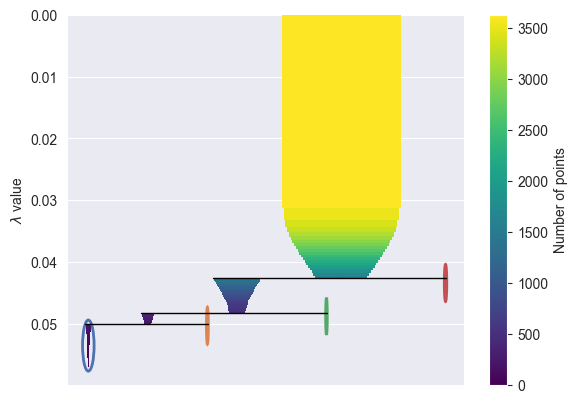

In [78]:
df_labels, hdbcan_labels, hdbcan_probabilities_ = create_hdbscan_clusters(20, sent_tiny, alpha=.2)

# відтинати хохло і укро?

In [176]:
prefixes_list = ['хохло', 'укро'] # list of prefixes to look for
# function to add space after prefix
def add_space(word, prefixes):
    for prefix in prefixes:
        if word.startswith(prefix):
            word = prefix + ' ' + word[len(prefix):]
    return word

def add_spaces_words(string, prefixes_list):
    result = ' '.join([add_space(word, prefixes=prefixes_list) for word in string.split(' ')])
    return result

In [177]:
add_spaces_words(df['text_lemmatized'][3], prefixes_list)

'раньше укро нацисты строить песчаный замок   но теперь пляж заминировать'

In [179]:
df['text_lemmatized_separated'] = df['text_lemmatized'].apply(lambda x: add_spaces_words(x, prefixes_list))

In [180]:
df

,text,text_clean,text_lemmatized,text_lemmatized_separated
0,Вагнер отправляет к бандере и прочим шайтанам ...,вагнер отправляет к бандере и прочим шайтанам ...,вагнер отправлять к бандере и прочим шайтан в ...,вагнер отправлять к бандере и прочим шайтан в ...
1,Тут понимаешь всё про метафизику этой войны. «...,тут понимаешь всё про метафизику этой войны ук...,тут понимать всё про метафизика этот война укр...,тут понимать всё про метафизика этот война укр...
2,"Наш источник сообщает, что остатки военной ави...",наш источник сообщает что остатки военной авиа...,наш источник сообщать что остаток военный авиа...,наш источник сообщать что остаток военный авиа...
3,Раньше укронацисты строили песчаные замки — но...,раньше укронацисты строили песчаные замки но ...,раньше укронацисты строить песчаный замок но...,раньше укро нацисты строить песчаный замок н...
4,Именно эти регионы являются настоящим рассадни...,именно эти регионы являются настоящим рассадни...,именно этот регион являться настоящий рассадни...,именно этот регион являться настоящий рассадни...
...,...,...,...,...
3623,Стоимость очередной подачки хохлам - $675 млн.,стоимость очередной подачки хохлам млн,стоимость очередной подачка хохол млн,стоимость очередной подачка хохол млн
3624,Хохлячие каналы ссылаясь на некую разведку соо...,хохлячие каналы ссылаясь на некую разведку соо...,хохлячие канал ссылаться на некий разведка соо...,хохлячие канал ссылаться на некий разведка соо...
3625,"Обсуждают недоукраинца Невзорова, Анну Нетребк...",обсуждают недоукраинца невзорова анну нетребко...,обсуждать недоукраинца невзоров анна нетребко ...,обсуждать недоукраинца невзоров анна нетребко ...
3626,И вот приходит коллективный Зусько и буквально...,и вот приходит коллективный зусько и буквально...,и вот приходить коллективный зусько и буквальн...,и вот приходить коллективный зусько и буквальн...


In [189]:
%%time
tf_idf_array = embed_tf(df, col='text_lemmatized_separated', max_df=0.3, min_df=0.01, ngram_range=(1,5))

CPU times: user 305 ms, sys: 25.4 ms, total: 330 ms
Wall time: 337 ms


We got 7 labels
____________-1
1236    признание одного из самых одиозных деятелей са...
2469    эксдепутат гд от лдпр мглущенко он же преступн...
626     очередное видео от хохлопетухов где они с бпла...
3309    винтовка продолжит отправлять к бандере украин...
2654    внимание информация только для одесских укропа...
Name: text_clean, dtype: object
____________0
148                                  нюхенфюрер салорейха
2006                                               помним
132                           обнуление подкрепления всук
1624                                               мощно 
1758    ключевая опасность в перми для варяга михаила ...
Name: text_clean, dtype: object
____________1
800     ликвидировано еще двое укронацистов   командир...
3437     куда важней что тамошние хохловоины всё осознали
543     запорожская аэс и город энергодар снова под об...
940     озеряновка выпущено  снарядов калибром  мм    ...
806     с разгромом в мариуполе самых законченных укро...
Name: t

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


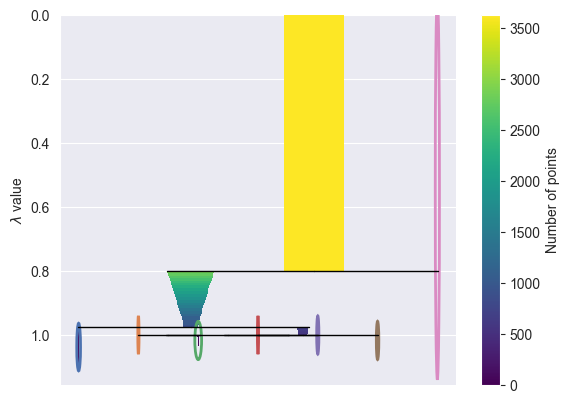

In [191]:
df_labels, tf2_dbcan_labels, tf2_hdbcan_probabilities_ = create_hdbscan_clusters(30, tf_idf_array, 0.8)

In [192]:
import fasttext

model_path = '/Users/katerynaburovova/PycharmProjects/dehumanization/fasttext_models/cc.ru.300.bin'
ftt_model = fasttext.load_model(model_path)

In [193]:
embedding_word = ftt_model.get_word_vector('привет')
sentence = 'Это тестовое предложение для получения векторного представления'
embedding_sent = ftt_model.get_sentence_vector(sentence)

In [194]:
embedding_word.shape, embedding_sent.shape

((300,), (300,))

In [229]:
df['ftt_emb'] = df['text_clean'].apply(lambda x: ftt_model.get_sentence_vector(x))

In [230]:
ftt_array = df['ftt_emb'].apply(pd.Series)

We got 6 labels
____________-1
384     спецназ фсб совместно с полицейскими задержал ...
2539                   теперь и сам чубайс покинул страну
298     тот случай когда укрозольдатэн размарадёрили ж...
2580    фсб задержала в ростовской области сторонника ...
1678                         народу немного а дело важное
Name: text_clean, dtype: object
____________0
861     всем утренний салам  всем кроме нацистов укрор...
872                    всем салам  всем кроме укропитеков
3232                        всем салам  всем кроме хохлов
815     всем читателям канала  утренний салам  всем кр...
157            всем утренний салам  всем кроме чубаноидов
Name: text_clean, dtype: object
____________1
1894     выздоровели за последние сутки в россии  человек
2140      новых случаев заражения коронавирусом выявил...
1469    в россии  случаев заражения коронавирусом за с...
2214    в россии выявлено   случаев коронавируса  за п...
2169    в москве за минувшие сутки скончались   пациен...
Name: t

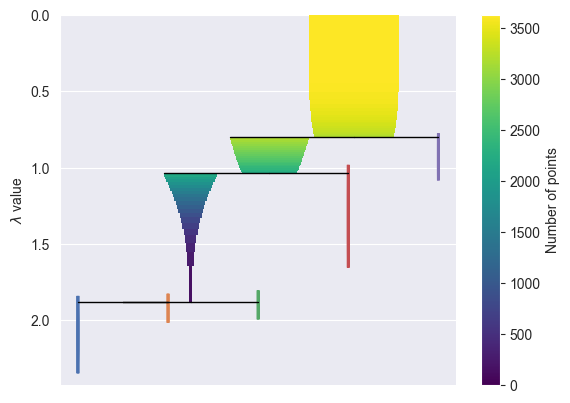

In [231]:
%%time
ftt_df_labels, ftt_hdbcan_labels, ftt_hdbcan_probabilities_ = create_hdbscan_clusters(5, ftt_array, alpha=.3)

In [238]:
df[ftt_df_labels['labels']==4]['text_clean'].iloc[1]

'например обещать перебить  процентов земляков как на картинке или выложить трупы в мешках перед сахибами с ес как вчера сотрудники корпорации зеленский и кочто интересно трупы неделю не изучают и не захоранивают украинец и после смерти должен служить свинорейху даже если его убил именно свинорейх свалить в израиль и вспомнить бабушкуеврейку с португальскими корнями а потом оттуда ныть что ты и есть россия'

## Kmeans

In [4]:
import pandas as pd
df_collocations = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/dataset_v_collocations.csv', index_col=0)

In [8]:
# %%time
# import ast
# df_collocations['core_noun_verb'] = df_collocations['core_noun_verb'].apply(ast.literal_eval)

In [9]:
df_collocations = df_collocations[['text', 'core_noun_verb_str', 'verb_obl_obj_str', 'appos_str', 'amod_str', 'nmod_str']]

In [10]:
df_collocations

,text,core_noun_verb_str,verb_obl_obj_str,appos_str,amod_str,nmod_str
0,Вагнер отправляет к бандере и прочим шайтанам ...,вагнер отправляет,"отправляет к бандере, отправляет бригады",батальон джохара дудаева,"прочим шайтанам, следующие бригады, шайтанский...","бандере бахмута районе, районе бахмута, бригад..."
1,Тут понимаешь всё про метафизику этой войны. «...,"укропы вышли, они вышли","тут понимаешь всё, тут понимаешь про метафизик...",NaN,NaN,"метафизику войны, укропы запада покровом, покр..."
2,"Наш источник сообщает, что остатки военной ави...",источник сообщает переброшена,переброшена на аэродром,аэродром рог,"военной авиации, долгинцево(кривой рог","остатки авиации, остатки укрорейха"
3,Раньше укронацисты строили песчаные замки — но...,"укронацисты раньше строили, укронацисты теперь...",раньше строили замки,NaN,песчаные замки,NaN
4,Именно эти регионы являются настоящим рассадни...,"регионы являются рассадником, регионы имеют","имеют для укронациков, имеют смысл",NaN,"настоящим рассадником, сакральный смысл, идеол...",рассадником укронацизма
...,...,...,...,...,...,...
3638,Стоимость очередной подачки хохлам - $675 млн.,NaN,NaN,NaN,"очередной подачки, - млн","стоимость подачки, подачки млн"
3639,Хохлячие каналы ссылаясь на некую разведку соо...,"каналы сообщают, вс готовы подорвать, зеленски...","ссылаясь на разведку, сообщают о том, подорват...",NaN,"хохлячие каналы, каховской гэс, масштабной тре...","каналы ссылаясь, дамбу гэс, шумок тревоги"
3640,"Обсуждают недоукраинца Невзорова, Анну Нетребк...",NaN,обсуждают недоукраинца,NaN,NaN,NaN
3641,И вот приходит коллективный Зусько и буквально...,"зусько вот приходит, зусько буквально начинает...","буквально начинает хохлов заваливать, завалива...",NaN,"коллективный зусько, ровном месте",трупами мобилизованных


In [16]:
%%time
df_collocations = preprocess_df(df_collocations)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_89492/3268668609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))


CPU times: user 18.9 s, sys: 129 ms, total: 19 s
Wall time: 19 s


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_89492/3268668609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))


In [18]:
df_collocations.drop(columns=['index'], inplace=True)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_89492/4110097691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collocations.drop(columns=['index'], inplace=True)


In [19]:
df_collocations

,text,core_noun_verb_str,verb_obl_obj_str,appos_str,amod_str,nmod_str,text_clean,text_lemmatized
0,Вагнер отправляет к бандере и прочим шайтанам ...,вагнер отправляет,"отправляет к бандере, отправляет бригады",батальон джохара дудаева,"прочим шайтанам, следующие бригады, шайтанский...","бандере бахмута районе, районе бахмута, бригад...",вагнер отправляет к бандере и прочим шайтанам ...,вагнер отправлять к бандере и прочим шайтан в ...
1,Тут понимаешь всё про метафизику этой войны. «...,"укропы вышли, они вышли","тут понимаешь всё, тут понимаешь про метафизик...",NaN,NaN,"метафизику войны, укропы запада покровом, покр...",тут понимаешь всё про метафизику этой войны ук...,тут понимать всё про метафизика этот война укр...
2,"Наш источник сообщает, что остатки военной ави...",источник сообщает переброшена,переброшена на аэродром,аэродром рог,"военной авиации, долгинцево(кривой рог","остатки авиации, остатки укрорейха",наш источник сообщает что остатки военной авиа...,наш источник сообщать что остаток военный авиа...
3,Раньше укронацисты строили песчаные замки — но...,"укронацисты раньше строили, укронацисты теперь...",раньше строили замки,NaN,песчаные замки,NaN,раньше укронацисты строили песчаные замки но ...,раньше укронацисты строить песчаный замок но...
4,Именно эти регионы являются настоящим рассадни...,"регионы являются рассадником, регионы имеют","имеют для укронациков, имеют смысл",NaN,"настоящим рассадником, сакральный смысл, идеол...",рассадником укронацизма,именно эти регионы являются настоящим рассадни...,именно этот регион являться настоящий рассадни...
...,...,...,...,...,...,...,...,...
3623,Стоимость очередной подачки хохлам - $675 млн.,NaN,NaN,NaN,"очередной подачки, - млн","стоимость подачки, подачки млн",стоимость очередной подачки хохлам млн,стоимость очередной подачка хохол млн
3624,Хохлячие каналы ссылаясь на некую разведку соо...,"каналы сообщают, вс готовы подорвать, зеленски...","ссылаясь на разведку, сообщают о том, подорват...",NaN,"хохлячие каналы, каховской гэс, масштабной тре...","каналы ссылаясь, дамбу гэс, шумок тревоги",хохлячие каналы ссылаясь на некую разведку соо...,хохлячие канал ссылаться на некий разведка соо...
3625,"Обсуждают недоукраинца Невзорова, Анну Нетребк...",NaN,обсуждают недоукраинца,NaN,NaN,NaN,обсуждают недоукраинца невзорова анну нетребко...,обсуждать недоукраинца невзоров анна нетребко ...
3626,И вот приходит коллективный Зусько и буквально...,"зусько вот приходит, зусько буквально начинает...","буквально начинает хохлов заваливать, завалива...",NaN,"коллективный зусько, ровном месте",трупами мобилизованных,и вот приходит коллективный зусько и буквально...,и вот приходить коллективный зусько и буквальн...


In [81]:
def cluster_with_kmeans(df, num_clusters, col_list):
    pd.set_option('display.max_colwidth', None)
    columns_to_cluster = col_list
    text_data = df[columns_to_cluster].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(text_data)
    n_clusters = num_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    cluster_labels_name = f'cluster_{n_clusters}_{"_".join(columns_to_cluster)}_{timestamp_str}'
    df[cluster_labels_name] = kmeans.labels_

    # Print the resulting clusters
    for i in range(n_clusters):
        print(f"Cluster {i}:")
        print(df_collocations['text'][df_collocations[cluster_labels_name] == i].sample(10))
        print('\n')
        print('\n')

    # return df


In [82]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# import time
# from datetime import datetime
#
#
# # Select the columns you want to use for clustering
# columns_to_cluster = ['text_lemmatized']
#
# # Convert the text data in the selected columns to a sequence of strings
# text_data = df_collocations[columns_to_cluster].apply(lambda x: ' '.join(x.astype(str)), axis=1)
#
# # Convert the text data to a matrix of TF-IDF features
# tfidf_vectorizer = TfidfVectorizer()
# X = tfidf_vectorizer.fit_transform(text_data)
# n_clusters = 2
#
# # Perform kmeans clustering with 2 clusters
# kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
#
# # Add the cluster labels to the original dataframe
# # df_collocations['cluster'] = kmeans.labels_
# # df_collocations[f'cluster_{n_clusters}_{"_".join(columns_to_cluster)}_{int(time.time())}'] = kmeans.labels_
# timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# df_collocations[f'cluster_{n_clusters}_{"_".join(columns_to_cluster)}_{timestamp_str}'] = kmeans.labels_
#
# # Print the resulting clusters
# for i in range(2):
#     print(f"Cluster {i}:")
#     print(df_collocations[df_collocations['cluster'] == i][columns_to_cluster])
#     print('\n')

In [85]:
cluster_with_kmeans(df_collocations, 3, ['core_noun_verb_str'])

Cluster 0:
627                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [84]:
# df_1['text'][df_1['cluster_3_core_noun_verb_str_2023-03-27_13-50-59']==1]

In [86]:
df_collocations.columns

Index(['text', 'core_noun_verb_str', 'verb_obl_obj_str', 'appos_str',
       'amod_str', 'nmod_str', 'text_clean', 'text_lemmatized', 'cluster',
       'cluster_2_text_lemmatized_1679913224',
       'cluster_2_text_lemmatized_2023-03-27_13-35-24',
       'cluster_2_text_lemmatized_2023-03-27_13-37-54',
       'cluster_2_core_noun_verb_str_2023-03-27_13-50-14',
       'cluster_3_core_noun_verb_str_2023-03-27_13-50-59',
       'cluster_3_core_noun_verb_str_2023-03-27_13-52-37',
       'cluster_3_core_noun_verb_str_2023-03-27_13-52-51',
       'cluster_3_core_noun_verb_str_2023-03-27_13-53-32',
       'cluster_3_core_noun_verb_str_2023-03-27_13-53-41',
       'cluster_3_core_noun_verb_str_2023-03-27_13-54-58',
       'cluster_3_core_noun_verb_str_2023-03-27_13-55-16',
       'cluster_3_core_noun_verb_str_2023-03-27_14-10-44',
       'cluster_3_core_noun_verb_str_2023-03-27_14-11-04',
       'cluster_3_core_noun_verb_str_2023-03-27_14-11-17',
       'cluster_3_core_noun_verb_str_2023-03-27

In [87]:
cluster_with_kmeans(df_collocations, 3, ['verb_obl_obj_str'])

Cluster 0:
907                                                                          У укронацистской армии и у укронацистского общества серьезные системные проблемы, во всем.
2308                                                                                                                                        Ну, то есть с бандеровцами.
2412                                                                                                                                             У Бандеры пополнение!”
1621                                                                                                                            От подписчика   На обои 😎🤙  @rosich_rus
178                                                                                                           Как нравится, бандерлог, тебе сценарий твоего будущего? 😎
1113                                                       Хорошее видео от 4 бригады НМ ЛНР https://t.me/Z4LPR/214, обработка позиций укронацистов п

In [88]:
cluster_with_kmeans(df_collocations, 3, ['amod_str'])

Cluster 0:
3477                                 Неонацисты из нацбатов воюют вместе с неграми  Ещё одно свидетельство, что территорию бывшей Украины оккупируют иностранцы.
2134                                                                                                                                                С любовью💧❤️
1856                                                                                                        Нашел, недолго покопавшись в своем архиве за август.
3409                                                                                                          Именно его, а не Чубайса, Навального или Волошина.
3261    Очень внимательно отнеситесь к посту укронациста (предположительно, это один из вурдалаков типо бабченко, сбежавших из России на Украину и далее везде).
1007                                                              Генерал укрорейха собрал дань в зоне ООС и попозировал у карт: https://t.me/black_list_VSU/327
1897                   

In [89]:
cluster_with_kmeans(df_collocations, 3, ['nmod_str'])

Cluster 0:
954         Трофейная "Восьмидесятка", которую наши бойцы отжали у чубатых морпехов в Мариуполе, успешно воюет на угледарском направлении.
2459                                                                   Свершилось. «Печку-Буржуйку» на хуторе переименовали в «Бандерпечь»
2948                                                                                                                    Сдавайся, хохоль!©
3495                                              Хохлы ещё не поняли, что в принципе могут делать с Донбассом буквально всё, что захотят.
1169    Укропские свинособаки издеваются даже над нашими двухсотыми. 18+ И после этого их можно называть «людьми»?  https://t.me/sofrezerv
2991                                                                        В итоге один ВСУшник застрелен, второй ранен, третий задержан.
2763                                      Неонацистские батальоны действительно прикрываются гражданскими, они их расстреливают и убивают.
1027            

In [90]:
cluster_with_kmeans(df_collocations, 3, ['nmod_str', 'core_noun_verb_str'])

Cluster 0:
1630                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [91]:
cluster_with_kmeans(df_collocations, 3, ['verb_obl_obj_str', 'core_noun_verb_str'])

Cluster 0:
3351    Луганское направление До бандеровской пропаганды не доходит, что если свой "бардак" разрисовать огромным количеством сакральных букв Z, машина не превратится в затрофеенную от народной милиции ЛНР. Просто потому что у них обычные БРДМ, а не модернизированные в Харькове или в Чехии  Но кто будет разбираться в деталях когда Зеленский заявил что перемога близко, и в нее надо просто уверовать
3475                                      Экс-разведчик подчеркнул, что нацбатальоны не расформировали путем арестов или ликвидации их участников: они стали частью украинских войск, и теперь их представители «повсюду». «Самое постыдное в этом всем то, что британские, американские и канадские солдаты ездили на Украину, чтобы тренировать эти неонацистские формирования, первым из которых был «Азов».
811                                                                                                                                                                                          

## LDA

In [103]:
from sklearn.decomposition import LatentDirichletAllocation

def cluster_with_lda(df, num_topics, col_list, col_to_print = 'text'):
    pd.set_option('display.max_colwidth', None)
    columns_to_cluster = col_list
    text_data = df[columns_to_cluster].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    tfidf_vectorizer = TfidfVectorizer()
    X = tfidf_vectorizer.fit_transform(text_data)
    n_topics = num_topics
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0).fit(X)
    timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    topic_labels_name = f'topic_{n_topics}_{"_".join(columns_to_cluster)}_{timestamp_str}'
    topic_labels = lda.transform(X).argmax(axis=1)
    df[topic_labels_name] = topic_labels

    # Print the resulting topics
    for i in range(n_topics):
        print(f"Topic {i}:")
        print(df[col_to_print][df[topic_labels_name] == i].sample(5))
        print('\n')
        # print('\n')

    # return df

In [104]:
cluster_with_lda(df_collocations, 3, ['verb_obl_obj_str', 'core_noun_verb_str'])

Topic 0:
2355                    Сегодня в Украине получил статус участника боевых действий 90-летний  Василий Семеляк, активный участник националистической организации ОУН-УПА  Кратко о подвигах этих нелюдей за время Второй Мировой Войны: От рук карателей - бандеровцев погибло 850 тысяч евреев, 220 тысяч поляков, более 400 тысяч советских военнопленных и еще 500 тысяч мирных украинцев.
329                                                                                                                                                                                                                                                                                                                                                                     Армяне про хохлорейх
1224                                                                                                                                                                                                                                 

In [105]:
cluster_with_lda(df_collocations, 5, ['verb_obl_obj_str', 'nmod_str'])

Topic 0:
322                           Внести свой вклад в Победу над укрорейхом, оказать помощь инженерно - сапёрной роте Шурави НМ ДНР, можно на карту Газпромбанка (МИР) 3562996583279966
2526                                                   Если бы хохлы всерьез рассматривали возможность большой войны с Россией, то давно объявили мобилизацию для охраны побережья.
2367                                                                                                         Сценаристы из "квартала" хлопцы креативные и не такое могут придумать.
2155                                                                                                           Молодые люди устроили секс-вечеринку на Хохловской площади в Москве.
2863    ​​Польский журналист – еврей ушёл из газеты после того, как она потребовала называть украинский полк «Азов» «ультраправым», а не «неонацистским», пишут СМИ.  @RadioStydoba
Name: text, dtype: object


Topic 1:
3288                                                  

In [119]:
cluster_with_lda(df_collocations, 5, ['verb_obl_obj_str', 'nmod_str'])

Topic 0:
3050                                                                 Вообще есть хорошее слово "криптобандеровец", я придумал в 2017 году, а вой стоит до сих пор.
1890                                             ❗️На утро 28 июня проголосовало (включая дистанционное голосование) 30 917 512 граждан (явка 28,46%) — данные ЦИК
3093                                                                                                   Переходим к новой тактике спецоперации против укронацистов.
874                                                                                                                                   Доброе утро людям и хохлам 😎
913     То есть, как минимум, три года "беззащитные" укронацики собирались вести боевые действия, а в итоге все равно оказались "безоружны перед лицом агрессора".
Name: text, dtype: object


Topic 1:
1866                                                                                                          Центробанк продолжит сдержива

In [112]:
cluster_with_lda(df_collocations, 5, ['verb_obl_obj_str', 'core_noun_verb_str'], col_to_print='verb_obl_obj_str')

Topic 0:
3409    NaN
766     NaN
769     NaN
2517    NaN
1497    NaN
Name: verb_obl_obj_str, dtype: object


Topic 1:
554                                                                                                                                        NaN
3282    ворваться на ходу, ворваться в киев, окружить части, разбить в том, разбить нацбаты, перетянуть на сторону, потом принудить зеленского
2972                                                                                                             добровольно изучаем мобильник
2877        заявил на лекции, после привел пример, сложились по разному, эмигрировавшого пароходом, оставшегося в ссср, расстрелянного по делу
2708                           думаю ручка знаете, уже знаете ручка, благодарим партнёров, благодарим за вооружение, благодарим за посредников
Name: verb_obl_obj_str, dtype: object


Topic 2:
419     показали ликбез, показали белорусов убивали, убивали под символикой, убивали белорусов, убивали во вов, сейчас

In [109]:
cluster_with_lda(df_collocations, 5, ['text_lemmatized'])

Topic 0:
927     Что если все эти мазепы, УНР, ЗУНР, бандеры и шухевичи, УПА и СС Галичина, майданы и война против Донбасса - и были ради вот этого: дуже доброго пана?🤔  И кляти москали всю жизнь мешали холопам найти этого самого дуже доброго пана? А?  Да быть такого ж не может.
443                                                                                                     И даже когда падёт нацисткий режим укробандер, он, если останется жив, будет прибывать в виртуальном мире, виртуальных побед, виртуального народа, виртуальной страны.
2075                                                                                                                                                                                                                                          Ну хоть не проституток выбирают.
2401                                                                                                                                                                              

In [113]:
cluster_with_lda(df_collocations, 5, ['amod_str', 'nmod_str'], col_to_print='amod_str')

Topic 0:
2240                           NaN
2357    неонацистской организацией
3039                  живого места
182                    детский сад
2129                           NaN
Name: amod_str, dtype: object


Topic 1:
2585    серьезные укрепы
2529    реальных потерях
627                  NaN
1357                 NaN
1010                 NaN
Name: amod_str, dtype: object


Topic 2:
3433    пленные всушники, украинскую сторону, остальных власти, украинской власти
823                                        украинских нацистов, вчерашней попойки
3551                                   острый психоз, данный г-н, соседней стране
656                                                        укронацистским каналам
375                                        обратную сторону, участливое отношение
Name: amod_str, dtype: object


Topic 3:
2509    недоброй целью, личного телефона, остервенелых бандеровцев, крепких слов
439                                           венского леса, европейских горо

In [114]:
cluster_with_lda(df_collocations, 5, ['amod_str', 'nmod_str'], col_to_print='nmod_str')

Topic 0:
2214    случаев коронавируса, случаев коронавируса, случаев в регионах
3361                                                 всушника из одшбр
583                                         режим хозяева, хозяева его
633                                                                NaN
2091                                                правда о натуралах
Name: nmod_str, dtype: object


Topic 1:
66                                                         тысяч бойцов
1940                                                           фото лиц
3617        деаноном людей, жалобы данных публикацию, публикацию данных
2201                                      плену   фсб, плену спустя лет
869     морковку племя обещаний, руины незалежной, руины по возможности
Name: nmod_str, dtype: object


Topic 2:
2048                             сентября года, полушария сферы, день равноденствия
3096                                                                            NaN
770                       

In [115]:
cluster_with_lda(df_collocations, 5, ['amod_str', 'nmod_str'])

Topic 0:
492                                                       Об этом мне доводилось говорить и ранее, когда мне говорил что ВСУ и укронацисты спешат на референдум.
1999                                                                           ❗️Россия достойно пройдет через посланные испытания, никаких сомнений нет — Путин
3430    🇺🇦"Намародерили, мля..."  ВСУшник жалуется, что для тактически отступающих бойцов не хватает места в кузове, так как он забит сувенирами.  👉 Подписаться
3490                                                                             На данный момент найдены несколько десятков убитых во время штурма неонацистов.
2237                                                                                                                                          Туша поймала тушу.
Name: text, dtype: object


Topic 1:
211                                                                               Мы ведь не фашисты какие - то из ВСУ. Откалибровать нацистов укроре

In [116]:
df_collocations

,text,core_noun_verb_str,verb_obl_obj_str,appos_str,amod_str,nmod_str,text_clean,text_lemmatized,cluster,cluster_2_text_lemmatized_1679913224,...,topic_5_verb_obl_obj_str_nmod_str_2023-03-27_14-43-09,topic_5_verb_obl_obj_str_nmod_str_2023-03-27_14-43-23,topic_5_verb_obl_obj_str_nmod_str_2023-03-27_14-43-45,topic_5_text_lemmatized_2023-03-27_14-48-25,topic_5_verb_obl_obj_str_core_noun_verb_str_2023-03-27_14-48-32,topic_5_verb_obl_obj_str_core_noun_verb_str_2023-03-27_14-49-40,topic_5_verb_obl_obj_str_core_noun_verb_str_2023-03-27_14-50-49,topic_5_amod_str_nmod_str_2023-03-27_14-56-53,topic_5_amod_str_nmod_str_2023-03-27_14-57-23,topic_5_amod_str_nmod_str_2023-03-27_14-57-56
0,Вагнер отправляет к бандере и прочим шайтанам в районе Бахмута следующие бригады: Шайтанский батальон Джохара Дудаева. 30-я механизированная бригада. 58-я механизированная пехотная бригада. 53-я механизированная бригада. 4-я бригада быстрого реагирования. 241-я бригада территориальной обороны. 71-я егерская бригада.,вагнер отправляет,"отправляет к бандере, отправляет бригады",батальон джохара дудаева,"прочим шайтанам, следующие бригады, шайтанский батальон, механизированная бригада, механизированная бригада, пехотная бригада, механизированная бригада, быстрого реагирования, территориальной обороны, егерская бригада","бандере бахмута районе, районе бахмута, бригада реагирования, бригада обороны",вагнер отправляет к бандере и прочим шайтанам в районе бахмута следующие бригады шайтанский батальон джохара дудаева я механизированная бригада я механизированная пехотная бригада я механизированная бригада я бригада быстрого реагирования я бригада территориальной обороны я егерская бригада,вагнер отправлять к бандере и прочим шайтан в район бахмут следующий бригада шайтанский батальон джохар дудаев я механизированный бригада я механизированный пехотный бригада я механизированный бригада я бригада быстрый реагирование я бригада территориальный оборона я егерский бригада,0,0,...,4,4,4,2,3,3,3,3,3,3
1,Тут понимаешь всё про метафизику этой войны. «Укропы» под покровом Запада вышли не против России — они вышли на войну с Богом.,"укропы вышли, они вышли","тут понимаешь всё, тут понимаешь про метафизику, вышли против россии, вышли на войну",NaN,NaN,"метафизику войны, укропы запада покровом, покровом запада, войну с богом",тут понимаешь всё про метафизику этой войны укропы под покровом запада вышли не против россии они вышли на войну с богом,тут понимать всё про метафизика этот война укроп под покров запад выйти не против россия они выйти на война с бог,1,1,...,4,4,4,2,3,3,3,2,2,2
2,"Наш источник сообщает, что остатки военной авиации укрорейха переброшена на аэродром Долгинцево(Кривой Рог)",источник сообщает переброшена,переброшена на аэродром,аэродром рог,"военной авиации, долгинцево(кривой рог","остатки авиации, остатки укрорейха",наш источник сообщает что остатки военной авиации укрорейха переброшена на аэродром долгинцевокривой рог,наш источник сообщать что остаток военный авиация укрорейха перебросить на аэродром долгинцевокривой рог,0,0,...,4,4,4,4,3,3,3,3,3,3
3,Раньше укронацисты строили песчаные замки — но теперь пляжи заминированы.,"укронацисты раньше строили, укронацисты теперь заминированы",раньше строили замки,NaN,песчаные замки,NaN,раньше укронацисты строили песчаные замки но теперь пляжи заминированы,раньше укронацисты строить песчаный замок но теперь пляж заминировать,0,0,...,4,4,4,2,0,0,0,1,1,1
4,Именно эти регионы являются настоящим рассадником укронацизма и имеют для укронациков сакральный идеологический смысл.,"регионы являются рассадником, регионы имеют","имеют для укронациков, имеют смысл",NaN,"настоящим рассадником, сакральный смысл, идеологический смысл",рассадником укронацизма,именно эти регионы являются настоящим рассадником укронацизма и имеют для укронациков сакральный идеологический смысл,именно этот регион являться настоящий рассадник укронацизма и иметь для укронациков сакральный идеологический смысл,0,0,...,3,3,3,4,2,2,2,3,3,3
...,...,...,...

In [117]:
cluster_with_lda(df_collocations, 5, ['nmod_str'], col_to_print='nmod_str')

Topic 0:
2222    постов про цены
3452        бригада тоф
1006                NaN
1644                NaN
853                 NaN
Name: nmod_str, dtype: object


Topic 1:
2273     заместитель командира, командира полка, обмен к бандере
457                      огонь пункту птур, птур опорному пункту
3605                                              тупость хохлов
993                                           удар по лисичанску
621     целостность укрорейха, укрорейха нато, территорию россии
Name: nmod_str, dtype: object


Topic 2:
2315    югу россии, сводки из донбасса, сводки безсонов, сводки видео, сводки с передка, сводки -, сводки репортер, сводки крыма, сводки по крыму, сводки сплетни новостями, новостями сплетни, сплетни полуострова, защиту пиироды, защиту без экошизы, защиту -, защиту алиса, защиту аналитика, защиту -, защиту мадуро, защиту -, эксперт луганска вопросам, вопросам луганска, друг донецка, голос мордора, сила в швейцарии, сила -, реальность сбу, реальность союз, союз